# Sentiment Analysis on Student Feedback in Engineering Education

## Introduction

In the field of engineering education, student feedback plays a vital role in assessing the effectiveness of teaching methods, course materials, and overall learning experiences. Sentiment analysis, a key component of data science, offers a powerful approach to analyze and extract valuable insights from student feedback. <br> <br>
The objective of this project is to perform sentiment analysis on the feedback provided by computer engineering students. By leveraging natural language processing (NLP) techniques and machine learning algorithms, we aim to uncover sentiments expressed in the feedback and gain a comprehensive understanding of student perceptions, satisfaction, and areas of improvement. <br> <br>
Through the analysis of student feedback, we can identify common themes, sentiment trends, and specific challenges faced by students. This valuable information can help inform the department and it's lectureres about the effectiveness of their teaching methodologies, course content, and student support systems. The insights derived from sentiment analysis on student feedback can drive evidence-based decision-making in engineering education. It enables the department to address concerns, make improvements, and create a positive learning environment that caters to the needs of their students.

## Data Collection
To get the data to use for this project, I utilized [Google Forms](https://docs.google.com/forms/d/e/1FAIpQLSeInhWFxECdegDDIYo7uY3-U-JHYyUDkTBQBw-KJxIvzYg_yA/viewform) to collect valuable feedback from students. The platform facilitated the collection of diverse responses, streamlined data collection, ensuring accuracy and efficiency in gathering student sentiments and  provided a comprehensive dataset for the sentiment analysis.

In [2]:
# import libraries and packages

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style='white')
from PIL import Image

import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tag import pos_tag
from nltk.sentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Load the spaCy English model
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
nlp = spacy.load('en_core_web_sm')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

import warnings
warnings.filterwarnings('ignore')

In [19]:
# load the dataset and show first 5 rows
df = pd.read_csv('Sentiment Analysis on Student Feedback.csv')
df.head()

,Timestamp,Course Code,Feedback,Previous Experience,Gender,Attendance,Course Difficulty,Study Hours (per week),Overall Satisfaction,Department,Unnamed: 11
0,2023/05/21 3:29:49 AM MDT,CPE 321,"The man is too fast in his teaching,he clearly...",No,Male,Regular,Challenging,21 hours,5,Yes,20/30GR072
1,2023/05/21 3:39:59 AM MDT,CPE 331,The class is dry but he really puts in efforts,Yes,Male,Regular,Moderate,7,8,Yes,19/30GR010
2,2023/05/21 3:57:54 AM MDT,CPE 321,The course is shit and it's a threat to my bra...,No,Male,Regular,Challenging,7hrs,4,Yes,20/30GR073
3,2023/05/21 4:52:08 AM MDT,CPE 321,"He no try at all, didn’t teach well.",No,Male,Regular,Challenging,12,1,Yes,NaN
4,2023/05/21 5:24:33 AM MDT,CPE 321,Ogbeni you sef know as e dae go,Yes,Male,Occasional,Difficult,How you want take study something wey you head...,0,Yes,NaN


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Timestamp               100 non-null    object
 1   Course Code             100 non-null    object
 2   Feedback                100 non-null    object
 3   Previous Experience     100 non-null    object
 4   Gender                  100 non-null    object
 5   Attendance              100 non-null    object
 6   Course Difficulty       100 non-null    object
 7   Study Hours (per week)  100 non-null    object
 8   Overall Satisfaction    100 non-null    int64 
 9   Department              100 non-null    object
 10  Unnamed: 11             3 non-null      object
dtypes: int64(1), object(10)
memory usage: 8.7+ KB


## Data Cleaning
Here, I'm going to clean the dataset as it can be seen to have some quality issues.

In [16]:
df.columns

Index(['Timestamp', 'Course Code', 'Feedback ', 'Sentiment',
       'Previous Experience ', 'Gender', 'Attendance', 'Course Difficulty ',
       'Study Hours (per week)', 'Overall Satisfaction ', 'Department ',
       'Unnamed: 11'],
      dtype='object')

In [17]:
df.columns = df.columns.str.strip()
print(df.columns)

Index(['Timestamp', 'Course Code', 'Feedback', 'Sentiment',
       'Previous Experience', 'Gender', 'Attendance', 'Course Difficulty',
       'Study Hours (per week)', 'Overall Satisfaction', 'Department',
       'Unnamed: 11'],
      dtype='object')


In [23]:
# drop unncessary column
df = df.drop(['Unnamed: 11'], axis=1)

# Convert the column to datetime format
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Extract the date and time into separate columns
df['Date'] = df['Timestamp'].dt.date
df['Time'] = df['Timestamp'].dt.time

# drop Timestamp column
df = df.drop(['Timestamp'], axis=1)

# corrections to "Study Hours (per week) column"
df['Study Hours (per week)'] = df['Study Hours (per week)'].str.extract(r'(\d+)').fillna(0).astype(int)

# replace 'LGBTQ 😂' with 'Male'
df['Gender'] = df['Gender'].replace('LGBTQ 😂', 'Male')

In [24]:
# overview of the data again
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Course Code             100 non-null    object
 1   Feedback                100 non-null    object
 2   Previous Experience     100 non-null    object
 3   Gender                  100 non-null    object
 4   Attendance              100 non-null    object
 5   Course Difficulty       100 non-null    object
 6   Study Hours (per week)  100 non-null    int32 
 7   Overall Satisfaction    100 non-null    int64 
 8   Department              100 non-null    object
 9   Date                    100 non-null    object
 10  Time                    100 non-null    object
dtypes: int32(1), int64(1), object(9)
memory usage: 8.3+ KB


In [25]:
# preview random sample of the data
df.sample(5)

,Course Code,Feedback,Previous Experience,Gender,Attendance,Course Difficulty,Study Hours (per week),Overall Satisfaction,Department,Date,Time
87,CPE 311,the best course and lecturer,Yes,Female,Regular,Easy,15,10,Yes,2023-05-30,14:47:59
5,CPE 321,"Omo, God will judge AK sha.\nYou don’t take a ...",No,Male,Regular,Difficult,9,1,Yes,2023-05-21,05:31:57
26,CPE 381,"The lecturer is good, I like him.",No,Female,Regular,Moderate,2,8,Yes,2023-05-26,14:43:35
48,CPE 331,Lecturer is good but the class is dry and equa...,No,Female,Irregular,Moderate,14,6,Yes,2023-05-30,13:51:12
55,CPE 321,Ah akanni. God will judge you.,No,Male,Irregular,Difficult,8,0,Yes,2023-05-30,14:03:32


## Data Preprocessing
Cleaning and preprocessing the data by removing stop words, punctuations, and special characters.

preprocess the feedback column

In [26]:
# Function to handle contractions
def handle_contractions(text):
    contractions = {
        "n't": " not",
        "'s": " is",
        "'re": " are",
        "'ve": " have",
        "'d": " would",
        "'ll": " will",
        "'m": " am"
    }

    words = text.split()
    for i in range(len(words)):
        if words[i] in contractions:
            words[i] = contractions[words[i]]
    return ' '.join(words)

# Function to preprocess text data
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Remove punctuation
    text = ''.join([char for char in text if char not in string.punctuation])

    # Tokenize the text
    tokens = word_tokenize(text)

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Handle contractions
    text = handle_contractions(' '.join(tokens))

    # Lemmatize the words
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in word_tokenize(text)]

    # Join tokens back into a single string
    processed_text = ' '.join(tokens)

    return processed_text

# Apply preprocessing to the 'Feedback' column
df['Processed_Feedback'] = df['Feedback'].apply(preprocess_text)

In [27]:
# lets check out the column
df['Processed_Feedback'][:10].to_frame()

,Processed_Feedback
0,man fast teachinghe clearly doesnt know teach ...
1,class dry really put effort
2,course shit threat brainthe teaching mode poor
3,try ’ teach well
4,ogbeni sef know e dae go
5,omo god judge ak sha ’ take class like expect ...
6,man good
7,e choke
8,teaching mode okay lecturer revision whats tau...
9,basically experience cpe ’ hard method employe...


calaculating the sentiment scores and it's corresponding labels

In the context of sentiment analysis, subjectivity scores can help distinguish between subjective statements that reflect personal opinions or emotions and objective statements that convey factual information. A high subjectivity score indicates a greater level of personal bias or opinion, while a low subjectivity score suggests a more objective or factual nature of the text.

Subjectivity is an important aspect to consider alongside polarity (sentiment) analysis, as it provides additional context and granularity in understanding the nature of the text and the subjective or objective nature of the statements being analyzed.
The interpretation of subjectivity scores depends on the specific context and objective of your analysis. In general, a high subjectivity score indicates a greater degree of personal opinion or bias expressed in the text. This can be valuable if you are interested in capturing and analyzing subjective or emotional content, such as in sentiment analysis or opinion mining.

However, if your goal is to analyze and classify objective or factual information, a low subjectivity score would be more desirable. A low subjectivity score suggests that the text contains more objective statements that are based on facts or present information without personal opinion or bias.

In [146]:
# # Calculate sentiment scores
# df['Sentiment_Score'] = df['Processed_Feedback'].apply(lambda x: TextBlob(x).sentiment.polarity)

# # Map sentiment scores to sentiment labels
# df['Sentiment_Label'] = df['Sentiment_Score'].apply(lambda x: 'Positive' if x > 0.0 else 
#                                                     'Negative' if x < 0.0 else 'Neutral')

In [28]:
# Calculate sentiment scores
df['Sentiment_Score'] = df['Processed_Feedback'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Calculate subjectivity scores
df['Subjectivity_Score'] = df['Processed_Feedback'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

# Map sentiment scores to sentiment labels
df['Sentiment_Label'] = df.apply(lambda row: 'Positive' if row['Sentiment_Score'] > 0.0 and row['Subjectivity_Score'] > 0.5 else 
                                        'Negative' if row['Sentiment_Score'] < 0.0 and row['Subjectivity_Score'] > 0.5 else 'Neutral', axis=1)

In [33]:
# lets checkout some random samples of the data
df.sample(5)

,Course Code,Feedback,Previous Experience,Gender,Attendance,Course Difficulty,Study Hours (per week),Overall Satisfaction,Department,Date,Time,Processed_Feedback,Sentiment_Score,Subjectivity_Score,Sentiment_Label
26,CPE 381,"The lecturer is good, I like him.",No,Female,Regular,Moderate,2,8,Yes,2023-05-26,14:43:35,lecturer good like,0.70,0.60,Positive
68,CPE 311,cool one from aunty,Yes,Male,Regular,Easy,15,10,Yes,2023-05-30,14:20:21,cool one aunty,0.35,0.65,Positive
49,CPE 341,I hate coding,No,Female,Regular,Challenging,6,5,Yes,2023-05-30,13:52:00,hate coding,-0.80,0.90,Negative
41,GSE 301,stress no dey the course,No,Female,Regular,Easy,0,9,Yes,2023-05-29,15:41:13,stress dey course,0.00,0.00,Neutral
93,GSE 301,GSE was very okay,Yes,Female,Irregular,Easy,5,9,Yes,2023-05-30,14:54:23,gse okay,0.50,0.50,Neutral


In [34]:
df[['Processed_Feedback', 'Sentiment_Label', 'Sentiment_Score', 'Subjectivity_Score']]

,Processed_Feedback,Sentiment_Label,Sentiment_Score,Subjectivity_Score
0,man fast teachinghe clearly doesnt know teach ...,Neutral,0.150000,0.491667
1,class dry really put effort,Neutral,0.066667,0.400000
2,course shit threat brainthe teaching mode poor,Negative,-0.300000,0.700000
3,try ’ teach well,Neutral,0.000000,0.000000
4,ogbeni sef know e dae go,Neutral,0.000000,0.000000
...,...,...,...,...
95,easy wahala,Positive,0.433333,0.833333
96,terrible way teaching idontcare attitude,Negative,-1.000000,1.000000
97,like coding,Neutral,0.000000,0.000000
98,practical hard top unit course haba,Positive,0.104167,0.520833


## Aspect-Based sentiment Analysis Metrics

### Summary statistics and metrics 

In [35]:
# Sentiment Analysis Metrics
sentiment_counts = df['Sentiment_Label'].value_counts()
average_sentiment_score = df['Sentiment_Score'].mean()
average_subj_score = df['Subjectivity_Score'].mean()

# Descriptive Statistics
study_hours_stats = df['Study Hours (per week)'].describe()
overall_satisfaction_stats = df['Overall Satisfaction'].describe()

# Categorical Metrics
course_code_counts = df['Course Code'].value_counts()
department_counts = df['Department'].value_counts()
sentiment_distribution = df.groupby('Course Code')['Sentiment_Label'].value_counts(normalize=True)

# Print the calculated metrics
print("Sentiment Analysis Metrics:")
print(sentiment_counts)
print("Average Sentiment Score:", average_sentiment_score)
print("Average SUbjectivity Score:", average_subj_score)
print("\nDescriptive Statistics - Study Hours:")
print(study_hours_stats)
print("\nDescriptive Statistics - Overall Satisfaction:")
print(overall_satisfaction_stats)
print("\nCategorical Metrics - Course Code Counts:")
print(course_code_counts)
print("\nCategorical Metrics - Department Counts:")
print(department_counts)
print("\nSentiment Distribution by Course Code:")
print(sentiment_distribution)

Sentiment Analysis Metrics:
Neutral     43
Positive    33
Negative    24
Name: Sentiment_Label, dtype: int64
Average Sentiment Score: 0.04996320346320346
Average SUbjectivity Score: 0.5081331168831169

Descriptive Statistics - Study Hours:
count    100.000000
mean       8.310000
std        5.506094
min        0.000000
25%        4.000000
50%        8.000000
75%       12.000000
max       21.000000
Name: Study Hours (per week), dtype: float64

Descriptive Statistics - Overall Satisfaction:
count    100.000000
mean       5.100000
std        3.599944
min        0.000000
25%        1.000000
50%        5.000000
75%        9.000000
max       10.000000
Name: Overall Satisfaction, dtype: float64

Categorical Metrics - Course Code Counts:
CPE 321    31
CPE 311    13
CPE 341    13
CPE 381    12
CPE 331    11
MEE 361    10
GSE 301    10
Name: Course Code, dtype: int64

Categorical Metrics - Department Counts:
Yes    99
No      1
Name: Department, dtype: int64

Sentiment Distribution by Course Code

### Analyze the frequency of specific keywords or phrases in the feedback

In [36]:
# analyze the frequency of specific keywords or phrases in the feedback
from collections import Counter

# The keywords or phrases of interest
keywords = ['shit', 'difficult', 'terrible', 'okay', 'best', 'worst', 'good']

# Concatenate all the preprocessed feedback into a single string
all_feedback = ' '.join(df['Processed_Feedback'])

# Tokenize the text into individual words
tokens = all_feedback.split()

# Count the frequency of each keyword in the feedback
keyword_frequency = Counter(tokens)

# Print the frequency of each keyword
for keyword in keywords:
    print(f"Frequency of '{keyword}': {keyword_frequency[keyword]}")


Frequency of 'shit': 1
Frequency of 'difficult': 4
Frequency of 'terrible': 5
Frequency of 'okay': 3
Frequency of 'best': 3
Frequency of 'worst': 2
Frequency of 'good': 8


### Text clustering to group similar feedback together

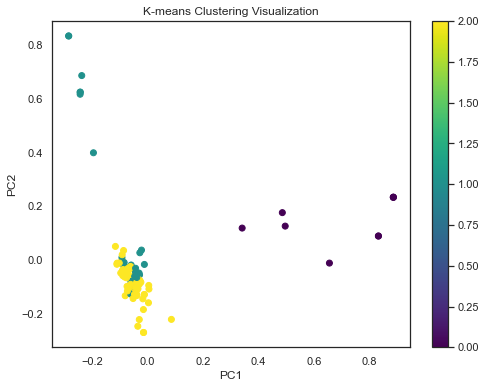

Top terms per cluster:
Cluster 0:
  nice
  course
  teaching
  scientist
  lecturer
  easy
  method
  job
  way
  go

Cluster 1:
  lecturer
  good
  teaching
  terrible
  course
  method
  time
  difficult
  much
  one

Cluster 2:
  course
  stress
  easy
  awful
  coding
  well
  code
  god
  akanni
  bad



In [39]:
# Create a TF-IDF vectorizer
vectorizer = TfidfVectorizer()

# Apply TF-IDF vectorization to the processed feedback text
tfidf_matrix = vectorizer.fit_transform(df['Processed_Feedback'])

# Perform K-means clustering
num_clusters = 3  # Specify the desired number of clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(tfidf_matrix)

# Assign cluster labels to the feedback data
df['Cluster'] = kmeans.labels_

# Apply dimensionality reduction using PCA
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(tfidf_matrix.toarray())

# Plot the clusters
plt.figure(figsize=(8, 6))
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=df['Cluster'], cmap='viridis')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('K-means Clustering Visualization')
plt.colorbar()
plt.show()

# Print the top terms for each cluster
print("Top terms per cluster:")
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(num_clusters):
    print(f"Cluster {i}:")
    for ind in order_centroids[i, :10]:
        print(f"  {terms[ind]}")
    print()

### Feature Engineering

In [41]:
df['Word_Count'] = df['Processed_Feedback'].apply(lambda x: len(x.split()))
df['Char_Count'] = df['Processed_Feedback'].apply(len)

## Topic Modeling
Implementing topic modeling techniques such as Latent Dirichlet Allocation (LDA) or Non-negative Matrix Factorization (NMF) to identify underlying topics or themes in the feedback data. This can provide deeper insights into the content and help analyze sentiment within specific topics.

In [42]:
# Create a CountVectorizer
vectorizer = CountVectorizer(max_features=1000, lowercase=True, stop_words='english', ngram_range=(1, 2))

# Apply CountVectorizer to the processed feedback text
dtm = vectorizer.fit_transform(df['Processed_Feedback'])

# Perform LDA topic modeling
num_topics = 7  # Specify the desired number of topics
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda.fit(dtm)

# Get the top words for each topic
feature_names = vectorizer.get_feature_names()
top_words = 10  # Specify the number of top words to retrieve for each topic
for topic_idx, topic in enumerate(lda.components_):
    print(f"Topic {topic_idx}:")
    print(" ".join([feature_names[i] for i in topic.argsort()[:-top_words - 1:-1]]))
    print()

Topic 0:
teaching method teaching method lecturer terrible method lecturer course know teach awful

Topic 1:
course lecturer easy time teaching bad difficult difficult lecturer course difficult taught

Topic 2:
course lecturer teaching course lecturer teaching mode mode especially bit exam worst

Topic 3:
course coding code god student akanni time class lecturer love code

Topic 4:
good lecturer course teaching like hard make lecturer good class god

Topic 5:
course nice lecturer class time awful wahala easy course class dry wey

Topic 6:
course stress dey hate course hard man hard okay best best course



## Emotion Detection
Identifying emotions in student feedback. The sentiment property of the TextBlob object to retrieve the sentiment scores which includes polarity (a value between -1 and 1 indicating the sentiment) and subjectivity (a value between 0 and 1 indicating the subjectivity of the text). <br>
**Emotion Polarity**: Emotion polarity measures the sentiment or emotional tone of a text. It indicates whether the text expresses a positive, negative, or neutral emotion. In the code provided, the polarity scores are obtained using the SentimentIntensityAnalyzer from NLTK. The polarity scores include values for positive, negative, and neutral sentiment. The sentiment polarity can help identify the overall sentiment or emotional tone of the feedback text. <br>
**Emotion Subjectivity**: Emotion subjectivity measures the degree of subjectivity or objectivity in the expression of emotions in a text. It indicates how much the text relies on personal opinions, beliefs, or experiences rather than factual or objective information. A higher subjectivity score suggests that the text is more influenced by personal perspectives or experiences.

In [43]:
def calculate_emotions(text):
    blob = TextBlob(text)
    emotion_scores = blob.sentiment.polarity, blob.sentiment.subjectivity
    return emotion_scores

# Apply emotion analysis to the feedback text
df['Emotion_Scores'] = df['Processed_Feedback'].apply(calculate_emotions)

# Extract emotion scores for each emotion category
df['Emotion_Polarity'] = df['Emotion_Scores'].apply(lambda x: x[0])
df['Emotion_Subjectivity'] = df['Emotion_Scores'].apply(lambda x: x[1])

# assign emotion labels based on polarity values
df['Emotion_Label'] = df['Emotion_Polarity'].apply(lambda x: 'Positive' if x > 0 else 'Negative' if x < 0 else 'Neutral')

# the resulting dataframe with emotion scores and labels
df[['Processed_Feedback', 'Emotion_Polarity', 'Emotion_Subjectivity', 'Emotion_Label']].head()

,Processed_Feedback,Emotion_Polarity,Emotion_Subjectivity,Emotion_Label
0,man fast teachinghe clearly doesnt know teach ...,0.150000,0.491667,Positive
1,class dry really put effort,0.066667,0.400000,Positive
2,course shit threat brainthe teaching mode poor,-0.300000,0.700000,Negative
3,try ’ teach well,0.000000,0.000000,Neutral
4,ogbeni sef know e dae go,0.000000,0.000000,Neutral


## Sentiment Data Visualization
Creating meaningful visualizations to gain insights and communicate findings effectively. Exploring different types of plots, charts, and graphs to showcase various aspects of the data and also analyzing the distribution of sentiment labels in the data to understand the overall sentiment polarity.

### Correlation Analysis
Exploring the correlation between sentiment and other variables in the dataset to identify potential relationships.

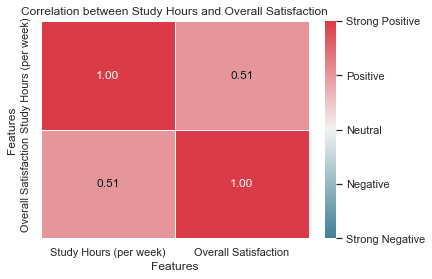

In [49]:
correlation_matrix = df[['Study Hours (per week)', 'Overall Satisfaction']].corr()

cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap=cmap, vmin=-1, vmax=1, linewidths=0.5)
plt.title('Correlation between Study Hours and Overall Satisfaction')

for i in range(correlation_matrix.shape[0]):
    for j in range(correlation_matrix.shape[1]):
        if i != j:
            text = '{:.2f}'.format(correlation_matrix.iloc[i, j])
            plt.text(j + 0.5, i + 0.5, text, ha='center', va='center', color='black')

colorbar = plt.gca().collections[0].colorbar
colorbar.set_ticks([-1, -0.5, 0, 0.5, 1])
colorbar.set_ticklabels(['Strong Negative', 'Negative', 'Neutral', 'Positive', 'Strong Positive'])

plt.xlabel('Features')
plt.ylabel('Features')
plt.show()

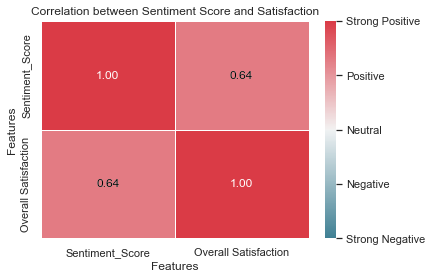

In [50]:
correlation_matrix = df[['Sentiment_Score', 'Overall Satisfaction']].corr()

cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap=cmap, vmin=-1, vmax=1, linewidths=0.5)
plt.title('Correlation between Sentiment Score and Satisfaction')

for i in range(correlation_matrix.shape[0]):
    for j in range(correlation_matrix.shape[1]):
        if i != j:
            text = '{:.2f}'.format(correlation_matrix.iloc[i, j])
            plt.text(j + 0.5, i + 0.5, text, ha='center', va='center', color='black')

colorbar = plt.gca().collections[0].colorbar
colorbar.set_ticks([-1, -0.5, 0, 0.5, 1])
colorbar.set_ticklabels(['Strong Negative', 'Negative', 'Neutral', 'Positive', 'Strong Positive'])

plt.xlabel('Features')
plt.ylabel('Features')
plt.show()

### Univariate Exploration

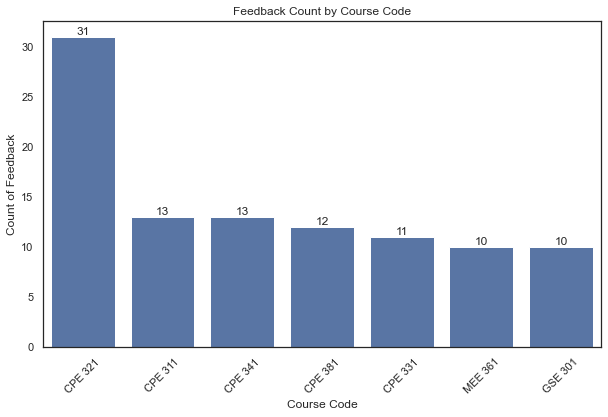

In [55]:
# Bar plot for Course Code
plt.figure(figsize=(10, 6))
color = sns.color_palette()[0]
order = df['Course Code'].value_counts().index
ax = sns.countplot(data=df, x='Course Code', color=color, order=order)
plt.xlabel('Course Code')
plt.ylabel('Count of Feedback')
plt.title('Feedback Count by Course Code')
plt.xticks(rotation=45)
ax.bar_label(ax.containers[0], fmt='%.0f', label_type='edge')
plt.show()

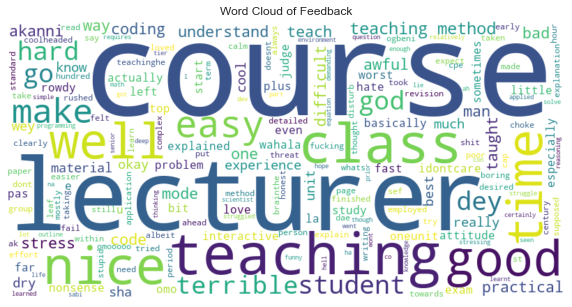

In [56]:
# Word cloud for Feedback: Combine all feedback into a single string
all_feedback = ' '.join(df['Processed_Feedback'])

plt.figure(figsize=(10, 6))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_feedback)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Feedback')
plt.show()

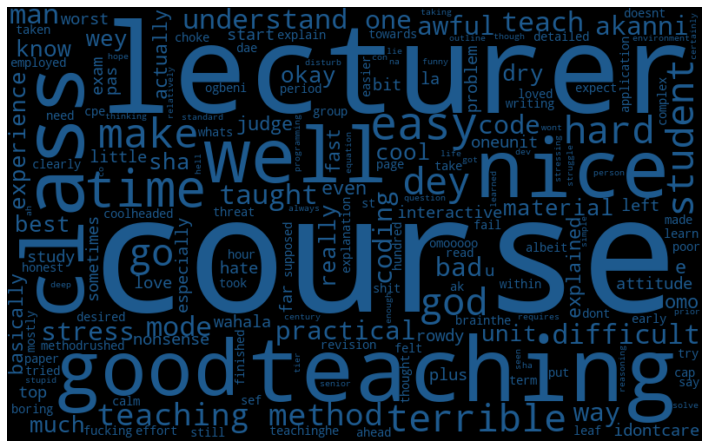

In [59]:
# Combine all feedback into a single string
all_feedback = ' '.join(df['Processed_Feedback'])

# Load the mask image
# mask_image = np.array(Image.open('apple.png'))

# Create a custom color function for the word cloud
def color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return '#1E5A8E'  # Set the text color

plt.figure(figsize=(10, 10))
wordcloud = WordCloud(width=800, height=500, background_color='black', stopwords=STOPWORDS,
                      color_func=color_func, min_font_size=10).generate(all_feedback)

# Set the interpolation to 'bilinear' for smoother edges
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout()
plt.show()

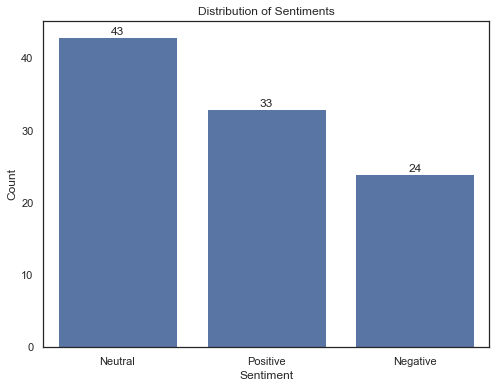

In [60]:
# Bar plot for Sentiment
plt.figure(figsize=(8, 6))
color = sns.color_palette()[0]
order = df['Sentiment_Label'].value_counts().index
ax = sns.countplot(data=df, x='Sentiment_Label', color=color, order=order)
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Distribution of Sentiments')
ax.bar_label(ax.containers[0], fmt='%.0f', label_type='edge')
plt.show()

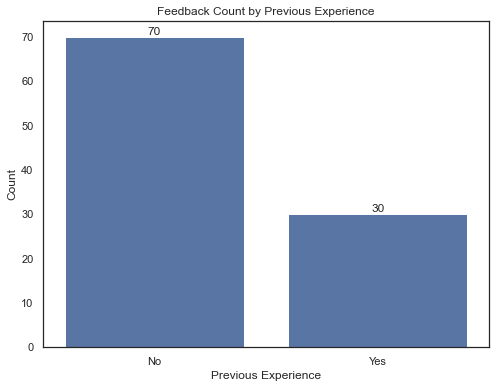

In [61]:
# Bar plot for Previous Experience
plt.figure(figsize=(8, 6))
color = sns.color_palette()[0]
ax = sns.countplot(data=df, x='Previous Experience', color=color)
plt.xlabel('Previous Experience')
plt.ylabel('Count')
plt.title('Feedback Count by Previous Experience')
ax.bar_label(ax.containers[0], fmt='%.0f', label_type='edge')
plt.show()

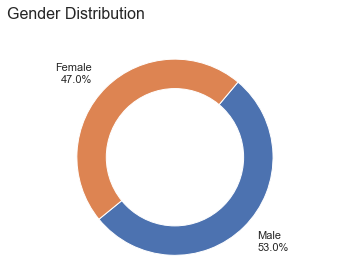

In [62]:
# Pie chart for Gender distribution
counts = df['Gender'].value_counts()
labels = [f"{gender}\n{count / len(df) * 100:.1f}%" for gender, count in counts.items()]

fig, ax = plt.subplots()
ax.pie(counts, labels=labels, startangle=50, counterclock=False, pctdistance=0.8, labeldistance=1.2)
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig.gca().add_artist(centre_circle)
ax.set_title('Gender Distribution', fontsize=16, loc='left', pad=30)
ax.axis('equal')
plt.show()

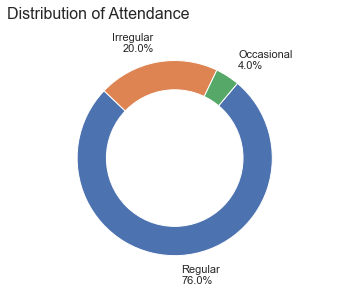

In [63]:
# Pie chart for Attendance
counts = df['Attendance'].value_counts()
labels = [f"{attendance}\n{count / len(df) * 100:.1f}%" for attendance, count in counts.items()]

fig, ax = plt.subplots()
ax.pie(counts, labels=labels, startangle=50, counterclock=False, pctdistance=0.8, labeldistance=1.2)
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig.gca().add_artist(centre_circle)
ax.set_title('Distribution of Attendance', fontsize=16, loc='left', pad=30)
ax.axis('equal')
plt.show()

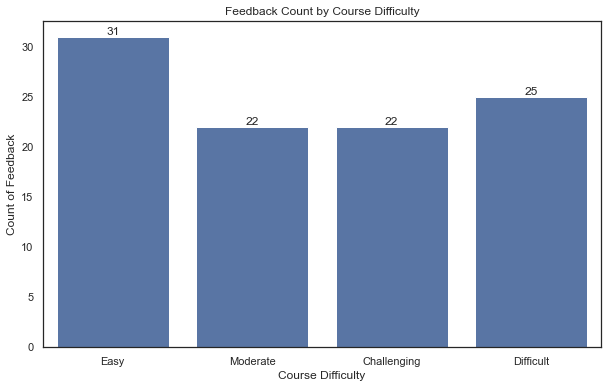

In [64]:
# Bar plot for Course Difficulty
plt.figure(figsize=(10, 6))
color = sns.color_palette()[0]
order = ['Easy', 'Moderate', 'Challenging', 'Difficult']
ax = sns.countplot(data=df, x='Course Difficulty', color=color, order=order)
plt.xlabel('Course Difficulty')
plt.ylabel('Count of Feedback')
plt.title('Feedback Count by Course Difficulty')
ax.bar_label(ax.containers[0], fmt='%.0f', label_type='edge')
plt.show();

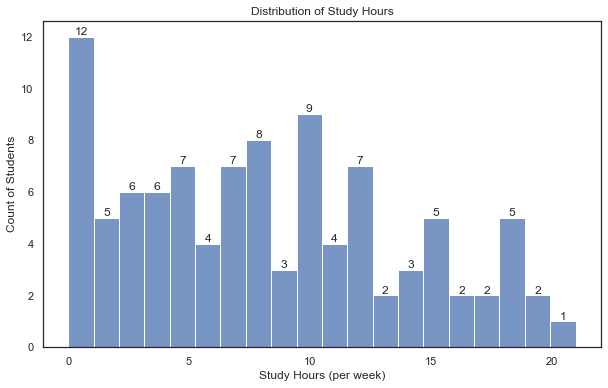

In [66]:
# Histogram for Study Hours (per week)
plt.figure(figsize=(10, 6))
color = sns.color_palette()[0]
ax = sns.histplot(data=df, x='Study Hours (per week)', bins=20, color=color)
plt.xlabel('Study Hours (per week)')
plt.ylabel('Count of Students')
plt.title('Distribution of Study Hours')
ax.bar_label(ax.containers[0], fmt='%.0f', label_type='edge')
plt.show()

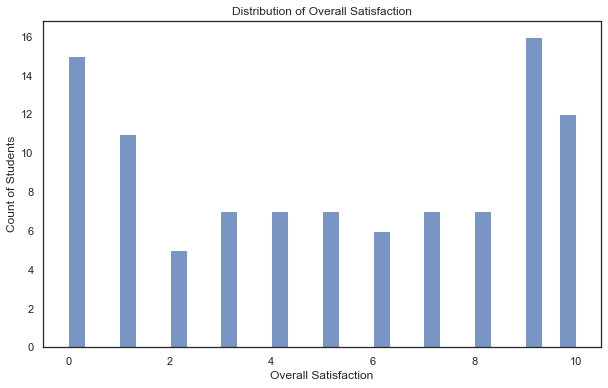

In [68]:
# Histogram for Overall Satisfaction
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='Overall Satisfaction', bins=30)
plt.xlabel('Overall Satisfaction')
plt.ylabel('Count of Students')
plt.title('Distribution of Overall Satisfaction')
plt.show()

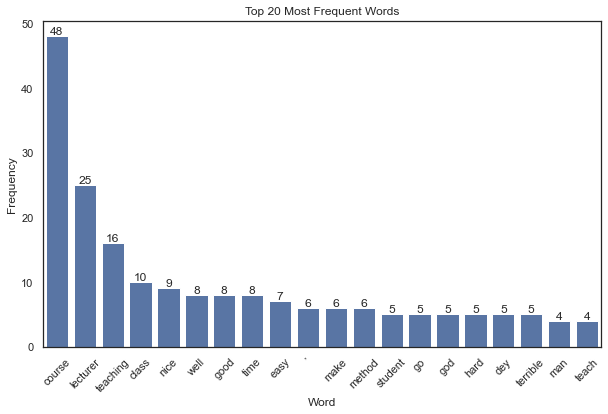

In [70]:
# Word Frequency Analysis
from collections import Counter
word_frequency = Counter(" ".join(df['Processed_Feedback']).split()).most_common(20)
plt.figure(figsize=(10, 6))
color = sns.color_palette()[0]
ax = sns.barplot(x=[word[0] for word in word_frequency], y=[word[1] for word in word_frequency], color=color)
ax.bar_label(ax.containers[0], fmt='%.0f', label_type='edge')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.title('Top 20 Most Frequent Words')
plt.xticks(rotation=45)
plt.show()

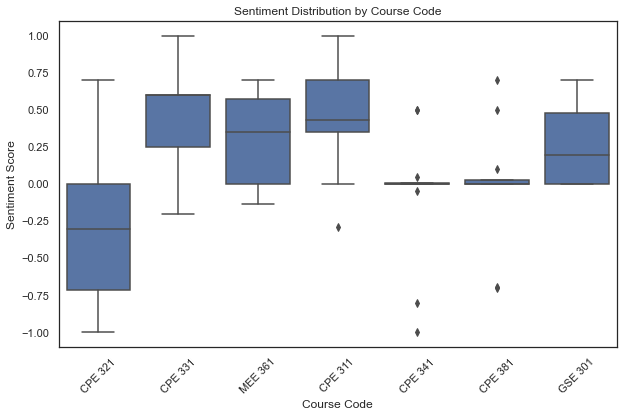

In [71]:
# Sentiment Box Plots
plt.figure(figsize=(10, 6))
color = sns.color_palette()[0]
sns.boxplot(data=df, x='Course Code', y='Sentiment_Score', color=color)
plt.xlabel('Course Code')
plt.ylabel('Sentiment Score')
plt.title('Sentiment Distribution by Course Code')
plt.xticks(rotation=45)
plt.show()

### Bivariate Exploration

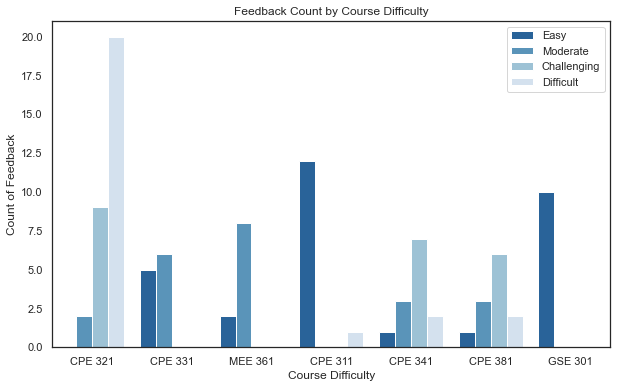

In [73]:
# Bar plot for Course Difficulty
plt.figure(figsize=(10, 6))
hue_order = ['Easy', 'Moderate', 'Challenging', 'Difficult']
sns.countplot(data=df, x='Course Code', hue='Course Difficulty', palette='Blues_r', hue_order=hue_order)
plt.xlabel('Course Difficulty')
plt.ylabel('Count of Feedback')
plt.title('Feedback Count by Course Difficulty')
plt.legend(loc=1)
plt.show();

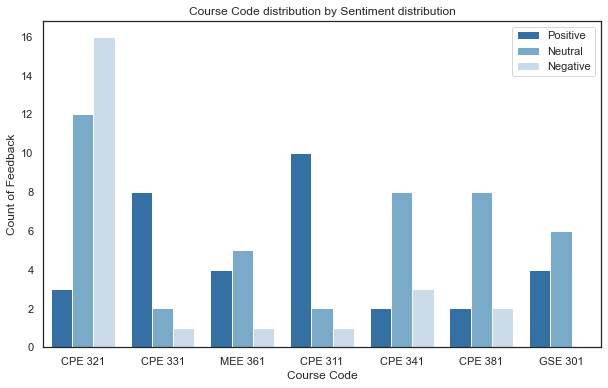

In [74]:
# Bar plot for Course Code distribution by Sentiment distribution
plt.figure(figsize=(10, 6))
hue_order = ['Positive', 'Neutral', 'Negative']
sns.countplot(data=df, x='Course Code', hue='Sentiment_Label', palette='Blues_r', hue_order=hue_order)
plt.xlabel('Course Code')
plt.ylabel('Count of Feedback')
plt.title('Course Code distribution by Sentiment distribution')
plt.legend(loc=1)
plt.show();

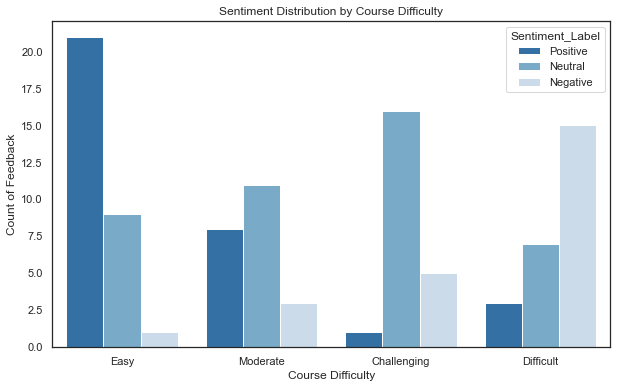

In [76]:
# Sentiment Distribution by Course Difficulty
plt.figure(figsize=(10, 6))
hue_order = ['Positive', 'Neutral', 'Negative']
order = ['Easy', 'Moderate', 'Challenging', 'Difficult']
sns.countplot(data=df, x='Course Difficulty', hue='Sentiment_Label', 
              palette='Blues_r', hue_order=hue_order, order=order)
plt.xlabel('Course Difficulty')
plt.ylabel('Count of Feedback')
plt.title('Sentiment Distribution by Course Difficulty')
plt.show()

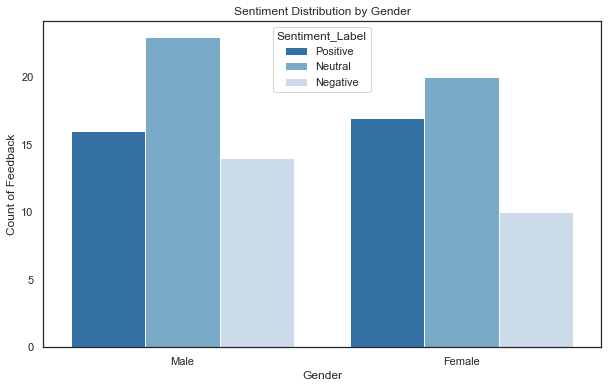

In [77]:
# Sentiment Distribution by Gender
plt.figure(figsize=(10, 6))
hue_order = ['Positive', 'Neutral', 'Negative']
sns.countplot(data=df, x='Gender', hue='Sentiment_Label', hue_order=hue_order, palette='Blues_r')
plt.xlabel('Gender')
plt.ylabel('Count of Feedback')
plt.title('Sentiment Distribution by Gender')
plt.show()

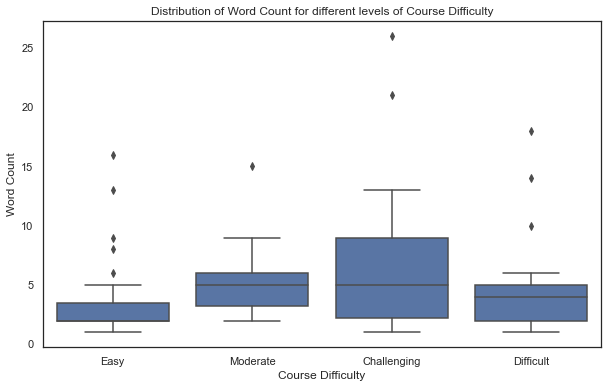

In [78]:
# Word Count distribution by course difficulty
plt.figure(figsize=(10, 6))
order = ['Easy', 'Moderate', 'Challenging', 'Difficult']
color = sns.color_palette()[0]
sns.boxplot(data=df, x='Course Difficulty', y='Word_Count', color=color, order=order)
plt.xlabel('Course Difficulty')
plt.ylabel('Word Count')
plt.title('Distribution of Word Count for different levels of Course Difficulty')
plt.show()

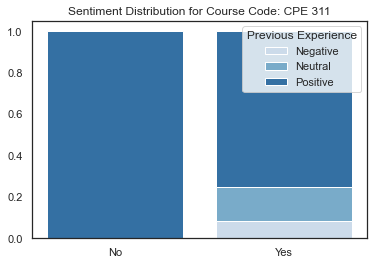

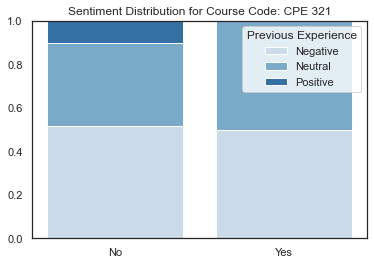

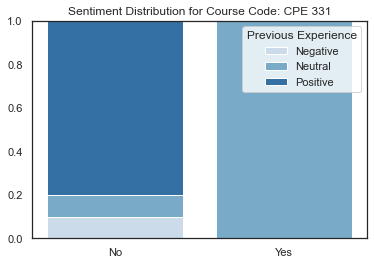

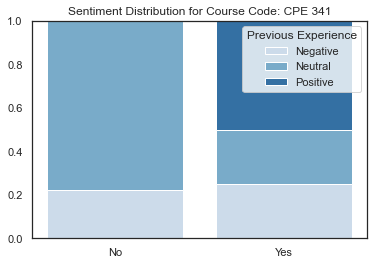

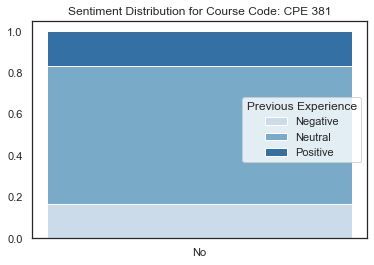

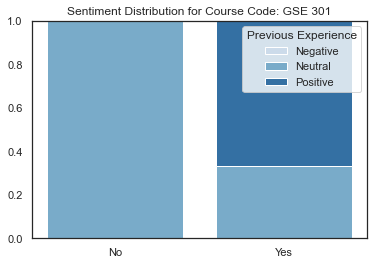

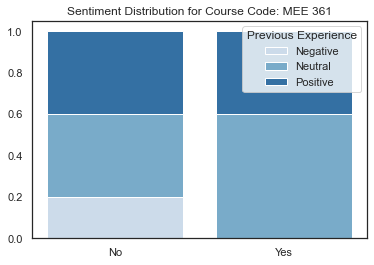

In [79]:
# Distribution of sentiment labels for different "Previous Experience" categories across various "Course Code" categories
subset_df = df[['Course Code', 'Previous Experience', 'Sentiment_Label']]

# Group the data by 'Course Code', 'Previous Experience', and 'Sentiment_Label' and count the occurrences
grouped_df = subset_df.groupby(['Course Code', 'Previous Experience', 'Sentiment_Label']).size().unstack(fill_value=0)

# Set the sentiment labels and their corresponding colors
sentiment_labels = ['Negative', 'Neutral', 'Positive']
colors = ['#CCDBEA', '#79ABC9', '#3470A3']

# Initialize the plot
fig, ax = plt.subplots()

# Loop through each 'Course Code' category
for i, course_code in enumerate(grouped_df.index.get_level_values('Course Code').unique()):
    # Get the data for the current 'Course Code'
    course_data = grouped_df.loc[course_code]
    
    # Calculate the relative frequency for each sentiment label
    total_counts = course_data.sum(axis=1)
    relative_freq = course_data.div(total_counts, axis=0)
    
    # Plot the stacked bar chart for each 'Previous Experience' category
    x = np.arange(len(course_data.index))
    bottom = np.zeros(len(course_data.index))
    for j, prev_exp in enumerate(relative_freq.columns):
        plt.bar(x, relative_freq[prev_exp], bottom=bottom, color=colors[j], label=prev_exp)
        bottom += relative_freq[prev_exp]
    
    # Adjust the x-axis labels
    plt.xticks(x, course_data.index)
    
    # Add a legend and set the title
    plt.legend(title='Previous Experience')
    plt.title(f'Sentiment Distribution for Course Code: {course_code}')
    
    # Show the plot
    plt.show()

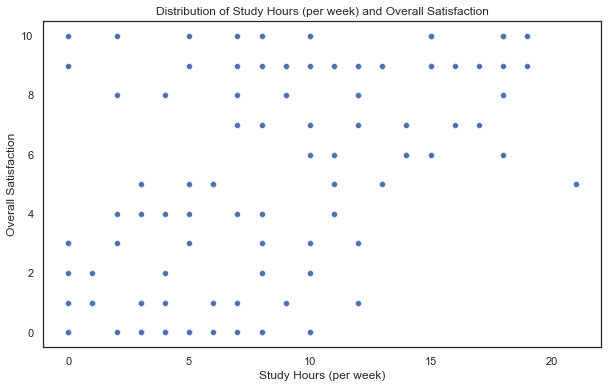

In [80]:
# Distribution of Study Hours (per week) and Overall Satisfaction
plt.figure(figsize=(10, 6))
color = sns.color_palette()[0]
sns.scatterplot(data=df, x='Study Hours (per week)', y='Overall Satisfaction', color=color)
plt.xlabel('Study Hours (per week)')
plt.ylabel('Overall Satisfaction')
plt.title('Distribution of Study Hours (per week) and Overall Satisfaction')
plt.show()

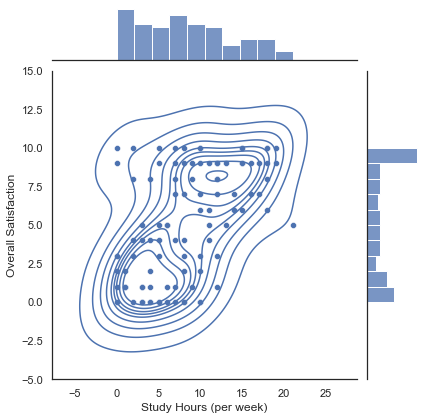

In [82]:
# Distribution of Study Hours (per week) and Overall Satisfaction
g = sns.jointplot(x='Study Hours (per week)', y='Overall Satisfaction',
             kind='scatter',
             data=df,
             marginal_kws=dict(bins=10))
g.plot_joint(sns.kdeplot)

plt.show()

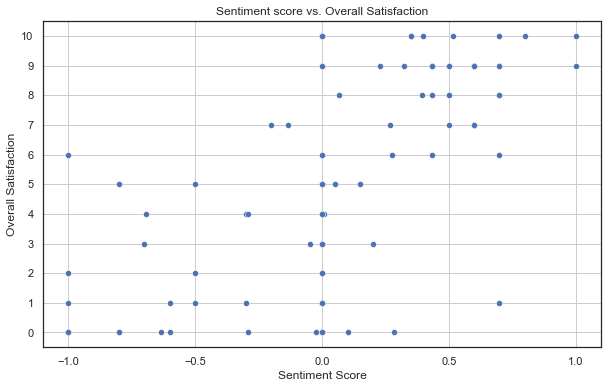

In [83]:
# Sentiment vs. Overall Satisfaction
plt.figure(figsize=(10, 6))
color = sns.color_palette()[0]
sns.scatterplot(x='Sentiment_Score', y='Overall Satisfaction', data=df, color=color)
plt.xlabel('Sentiment Score')
plt.ylabel('Overall Satisfaction')
plt.title('Sentiment score vs. Overall Satisfaction')
plt.xticks(np.arange(-1, 1.1, 0.5))
plt.yticks(np.arange(0, 11))
plt.grid(True)
plt.show()

<Figure size 720x432 with 0 Axes>

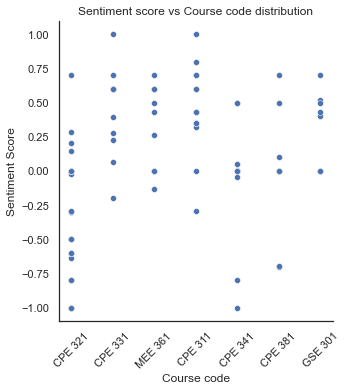

In [86]:
# Sentiment score Distribution by Course code
plt.figure(figsize=(10, 6))
color = sns.color_palette()[0]
sns.relplot(data=df, x='Course Code',y = 'Sentiment_Score', color=color, kind='scatter')
plt.xlabel('Course code')
plt.ylabel('Sentiment Score')
plt.title('Sentiment score vs Course code distribution')
plt.xticks(rotation=45)
plt.show();

### Multivariate Exploration

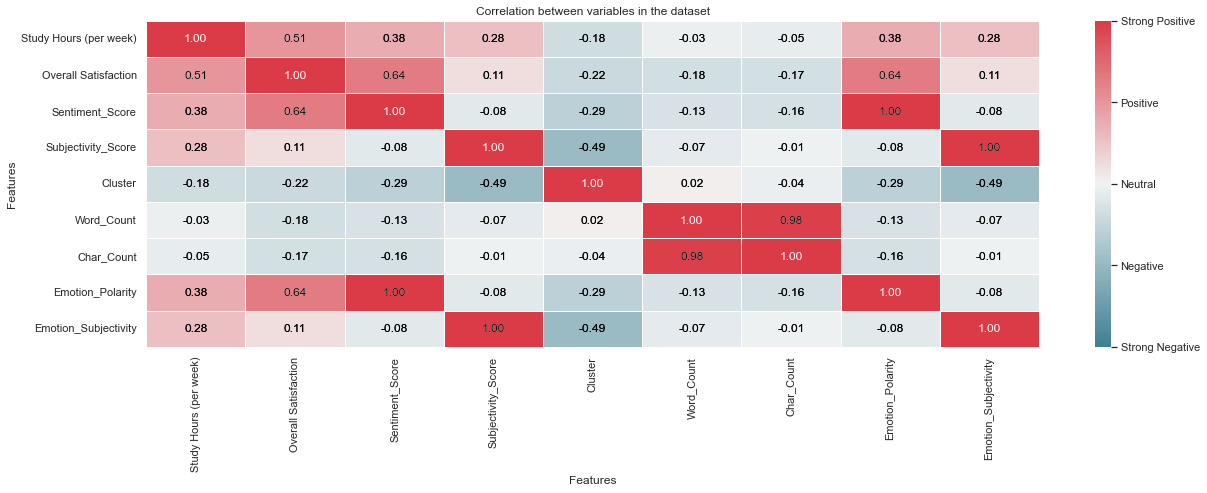

In [87]:
# correlation matrix of all variables in the data
correlation_matrix = df.corr()

plt.figure(figsize=[20, 6])
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap=cmap, vmin=-1, vmax=1, linewidths=0.5)
plt.title('Correlation between variables in the dataset')

for i in range(correlation_matrix.shape[0]):
    for j in range(correlation_matrix.shape[1]):
        if i != j:
            text = '{:.2f}'.format(correlation_matrix.iloc[i, j])
            plt.text(j + 0.5, i + 0.5, text, ha='center', va='center', color='black')

colorbar = plt.gca().collections[0].colorbar
colorbar.set_ticks([-1, -0.5, 0, 0.5, 1])
colorbar.set_ticklabels(['Strong Negative', 'Negative', 'Neutral', 'Positive', 'Strong Positive'])

plt.xlabel('Features')
plt.ylabel('Features')
plt.show()

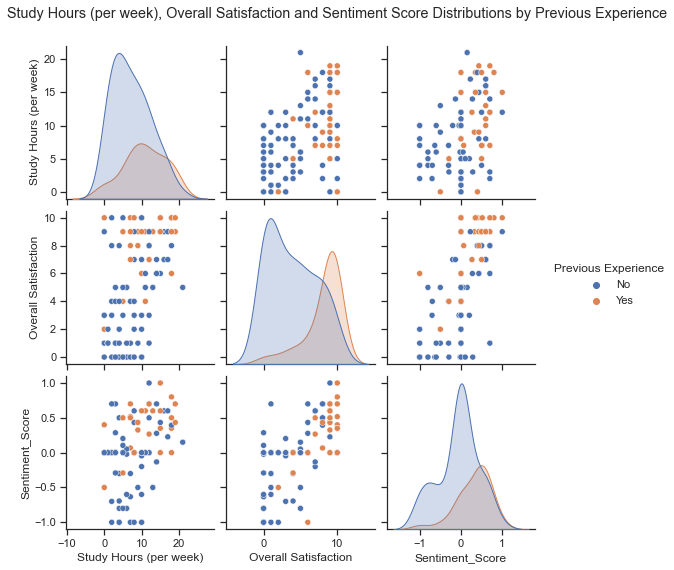

In [88]:
sns.set(style='ticks')
sns.pairplot(data=df, vars=['Study Hours (per week)', 'Overall Satisfaction', 
                            'Sentiment_Score'], hue='Previous Experience', markers='o')
plt.suptitle('Study Hours (per week), Overall Satisfaction and Sentiment Score Distributions by Previous Experience',
             y=1.05)
plt.show();

## Feedback Analysis

In conclusion, the sentiment analysis project on student feedback in engineering education has yielded valuable insights into the sentiments expressed by students, providing recommendations for improvement. Analyzing the sentiment distribution reveals that the majority of feedback is classified as `Neutral`, followed by `Positive` and `Negative` sentiments. This indicates a diverse range of sentiments expressed by students, with a notable presence of positive and neutral sentiments. The prevalence of `Neutral` sentiments in the student feedback sentiment analysis may suggest that students are expressing a balanced perspective or a lack of strong sentiment towards their educational experience. It might also indicate that students are providing objective observations or factual statements without expressing a clear positive or negative sentiment. Furthermore, it was observed that a majority of students had no previous experience, adding to the context of the analysis.

The sentiment analysis revealed variations in sentiment across different courses, suggesting that certain courses may have specific strengths or areas for improvement. Among the courses, CPE 321 was identified as the most difficult, with the majority of negative sentiments expressed in relation to this course. Furthermore, an interesting gender disparity was observed in the sentiment analysis. While both male and female students expressed negative sentiments, it was more prevalent among the male students. On the other hand, the female students had a higher proportion of positive sentiments compared to the male students. Additionally, the male students had a higher proportion of neutral sentiments. These findings highlight the importance of considering gender as a factor in understanding and addressing the sentiment dynamics in student feedback. It was also noted that the easy courses had the most number of positive sentiments. Specifically, CPE 321 & CPE 341 had the lowest sentiment scores, while CPE 311 received the highest sentiment score. The correlation between the Sentiment score and Overall satisfaction suggests that the sentiment expressed in the feedback aligns closely with the overall satisfaction level reported by students. This indicates that students' sentiments play a significant role in shaping their overall satisfaction with the educational experience. Furthermore, the perfect correlation between the Sentiment score and Emotion Polarity suggests that the sentiment analysis effectively captures the polarity of emotions expressed by students. Additionally, the high correlation between study hours and overall satisfaction implies that the amount of time students dedicate to studying may positively influence their overall satisfaction with the education they receive.

In addition to examining sentiment based on course and gender, the analysis explored other attributes to identify potential variations that could inform targeted interventions or support. By employing techniques such as topic modeling, key themes and topics discussed by students were uncovered, providing further context to their sentiments. These insights can guide curriculum development, faculty training, or resource allocation to address specific areas of concern or capitalize on identified strengths.

The sentiment analysis not only sheds light on the sentiments of students in the department but also provides actionable insights for improvement. This project serves as a foundation for ongoing feedback analysis and continuous enhancement of the educational experience based on student sentiments. By leveraging the power of sentiment analysis, the department can proactively address issues, tailor interventions, and strive for continuous improvement in engineering education. Moreover, the findings highlight the need for targeted interventions in specific courses, particularly CPE 321, where students expressed a higher number of negative sentiments. By addressing these concerns, the department can work towards providing a more fulfilling and satisfactory learning environment for the students. These findings can serve as a basis for informed decision-making, allowing the department to address concerns, capitalize on strengths, and continuously enhance the quality of education provided to students.

In conclusion, the sentiment analysis of student feedback in engineering education has yielded valuable insights and recommendations for improvement. The sentiment distribution indicates a majority of `Neutral` feedback, suggesting a balanced perspective or lack of strong sentiment. Gender disparity shows both male and female students expressing negative sentiments, with females expressing more positive sentiments and males having more neutral sentiments. Variation across courses highlights specific strengths or areas for improvement, with CPE 321 being the most challenging. CPE 341 and CPE 311 received lower sentiment scores, while CPE 311 had the highest sentiment score. Correlations reveal the alignment of sentiment score with overall satisfaction and perfect correlation with emotion polarity. Study hours positively influence overall satisfaction. Topic modeling uncovers key themes discussed by students. These findings can serve as a basis for informed decision-making, allowing the department to address concerns, capitalize on strengths, and continuously enhance the quality of education provided to students. The sentiment analysis serves as a foundation for continuous improvement in engineering education, with targeted interventions required for courses with more negative sentiments, particularly CPE 321. Informed decision-making enhances the educational experience, ensuring a fulfilling and satisfactory learning environment for students.